In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

In [2]:
data = pd.read_pickle('df_tesco_marker_V3.pkl')

In [3]:
data.shape

(61990, 56)

In [4]:
data.columns

Index(['Site Number', 'Site Name', 'Transaction Date', 'Total Sales Value',
       'Total Baskets', 'Sales Baskets With Fuel', 'Baskets With Fuel',
       'Site ID', 'PBL', 'CRUSO_priceADO', 'CRUSO_priceUL95', 'volumeADO',
       'volumeUL95', 'sales_valADO', 'sales_valUL95', 'totalSalesEsso',
       'pct_dev', 'diff_shop_esso', 'SiteCode', 'SiteName', 'Date',
       'UL 95_ Sales Transaction Volume', 'UL 95_ Approved Price',
       'UL 95_ Marker Price', 'UL 95_ Approved Price Vs Marker Price',
       'ADO_ Sales Transaction Volume', 'ADO_ Approved Price',
       'ADO_ Marker Price', 'ADO_ Approved Price Vs Marker Price',
       'avgUL95VolSite', 'avgADOVolSite', 'diffAdoVol', 'diffUL95Vol',
       'diffAdoVolpct', 'diffUL95Volpct', 'diffAdoPricePct',
       'diffUL95PricePct', 'avgShopSalesFromFuelSiteWise',
       'pctChgShopSalesFromFuel', 'shopSales', 'avgShopSalesSiteWise',
       'ShopSalesPctChgFromAvg', 'AdoApprPriceChgPct', 'UL95AppPriceChgPct',
       'avgFuelSalesEssoSiteWi

In [5]:
# calcualting exclusive shop sales and shop slaes from fuel for sites:
data['exclShopSales'] = data['Total Sales Value']-data['Sales Baskets With Fuel']
data['shopSalesFromFuel'] = data['Sales Baskets With Fuel']-data['totalSalesEsso']

In [6]:
# selecting only required data for elasticity calculation:
seldf = data.loc[:,['Site Number', 'shopSalesFromFuel', 'ADO_ Approved Price','ADO_ Marker Price']]

In [7]:
seldf.drop(list(seldf[seldf['shopSalesFromFuel'] == 0].index), axis=0, inplace=True)

In [8]:
seldf.describe()

Site Number  shopSalesFromFuel  ADO_ Approved Price  ADO_ Marker Price
count  61990.000000       61990.000000         61990.000000       61990.000000
mean    3745.035441        2201.566828           130.520648         129.855688
std     1358.669466         827.340172             2.921055           2.677766
min     2001.000000       -2358.313230           118.900000         120.460000
25%     2553.000000        1622.594022           128.900000         128.220000
50%     3156.000000        2099.136680           129.900000         129.860000
75%     5288.000000        2686.052192           131.900000         131.500000
max     6119.000000       13649.831100           140.900000         140.900000

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
def get_plot(df):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'])
    line = slope*X+intercept

    df['Fitted log(S0)'] = np.concatenate(line)

    fig = go.Figure(data=[
        go.Scatter(x= df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'],mode='markers', name='Actual', marker_color = 'gray'),
        go.Line(x= df['Actual log(P0/Pbar)'], y=df['Fitted log(S0)'], name='Fit', marker_color = 'firebrick')    
    ])

    fig.update_layout(
        #title = selectedCountry+' - Road Fuel Demand',
        yaxis_title="log(S0)",
        xaxis_title="log(P0/Pbar)",
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
    #fig.show()
    #fig.write_image("fig1.pdf")
    return fig

In [11]:
elasticity = []
logSbar    = []
corrCoef   = []
pVal       = []
rmse       = []
r2         = []
mape       = []

pd.options.mode.chained_assignment = None  # default='warn'

for i in range(len(seldf['Site Number'].unique())): #for all sites 
    df = seldf[seldf['Site Number'] == seldf['Site Number'].unique()[i]]
    df.drop('Site Number', axis=1, inplace=True)
    df.columns = ['shopSales', 'P0', 'Pbar']
    data_df = pd.DataFrame()
    y = np.log(df['shopSales'].dropna().values).reshape(-1,1)
    pdiv = df['P0']/df['Pbar']
    X = np.log(pdiv.dropna()).values.reshape(-1,1)
    data_df = pd.concat([data_df, pd.DataFrame({'Actual log(S0)': y.flatten(), 'Actual log(P0/Pbar)': X.flatten()})], axis=0)
    data_df.drop(list(data_df[data_df.isnull().any(axis=1)].index), axis=0, inplace=True)
    #get_plot(data_df)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df['Actual log(P0/Pbar)'], y=data_df['Actual log(S0)'])
    elasticity.append(slope)
    logSbar.append(intercept)
    corrCoef.append(r_value)
    pVal.append(p_value)
    y_final = data_df['Actual log(S0)']
    X_final = data_df['Actual log(P0/Pbar)']
    rmse.append(round(np.sqrt(metrics.mean_squared_error(y_final, slope*X_final+intercept)),4))
    r2.append(round(metrics.r2_score(y_final, slope*X_final+intercept),4))
    mape.append(round(mean_absolute_percentage_error(y_final,slope*X_final+intercept),4))   

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log

/opt/app-root/lib/python3.6/site-packages/ipyker

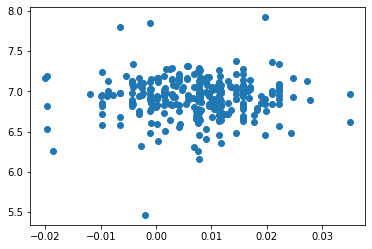

In [12]:
import matplotlib.pyplot as plt
plt.scatter(data_df['Actual log(P0/Pbar)'], data_df['Actual log(S0)'])

In [13]:
# df = data_df
# slope, intercept, r_value, p_value, std_err = stats.linregress(df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'])
# line = slope*X+intercept

# df['Fitted log(S0)'] = np.concatenate(line)

# fig = go.Figure(data=[
#     go.Scatter(x= df['Actual log(P0/Pbar)'], y=df['Actual log(S0)'],mode='markers', name='Actual', marker_color = 'gray'),
#     go.Line(x= df['Actual log(P0/Pbar)'], y=df['Fitted log(S0)'], name='Fit', marker_color = 'firebrick')    
# ])

# fig.update_layout(
#     #title = selectedCountry+' - Road Fuel Demand',
#     yaxis_title="log(S0)",
#     xaxis_title="log(P0/Pbar)",
#     plot_bgcolor='rgba(0,0,0,0)'
# )

# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
# fig.show()

In [14]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(data_df['Actual log(P0/Pbar)'], y=data_df['Actual log(S0)'])
# elasticity.append(slope)
# logSbar.append(intercept)
# corrCoef.append(r_value)
# pVal.append(p_value)
# rmse.append(round(np.sqrt(metrics.mean_squared_error(y, slope*X+intercept)),4))
# r2.append(round(metrics.r2_score(y, slope*X+intercept),4))
# mape.append(round(mean_absolute_percentage_error(y,slope*X+intercept),4))   

In [15]:
result_df = pd.DataFrame({'elasticity': elasticity, 'constant': logSbar, 'p-value':pVal, 'r2':r2, 'mape': mape, 'rmse':rmse})

In [16]:
result_df

elasticity  constant   p-value      r2    mape    rmse
0     -0.568106  6.862045  0.723522  0.0004  2.6126  0.2728
1      0.490800  7.466884  0.753448  0.0003  2.0457  0.1947
2     -0.956435  7.919746  0.535944  0.0012  1.5736  0.1648
3      2.948387  7.572485  0.170663  0.0059  2.9924  0.3848
4     -1.798675  7.545620  0.388777  0.0025  2.9490  0.3038
..          ...       ...       ...     ...     ...     ...
191   -0.718636  7.902503  0.636104  0.0007  1.7310  0.1889
192    0.666511  7.960034  0.720312  0.0004  1.7630  0.1785
193    2.367638  7.645481  0.307164  0.0035  2.1681  0.2221
194    1.426446  7.540895  0.293548  0.0034  2.0257  0.2227
195    0.525556  6.920294  0.732499  0.0004  2.5429  0.2436

[196 rows x 6 columns]

In [17]:
result_df[result_df['p-value'] < 0.05].shape

(63, 6)

In [18]:
import plotly.express as px
fig = px.histogram(result_df, x="elasticity", nbins=20)
fig.show()

In [19]:
result_df.to_csv("ADO_shopSalesFromFuel_elasticity")

In [20]:
result_df.describe()

elasticity    constant       p-value          r2        mape  \
count  196.000000  196.000000  1.960000e+02  196.000000  196.000000   
mean     0.058230    7.630664  3.154473e-01    0.013689    2.149316   
std      3.915882    0.322901  3.135524e-01    0.025236    0.730994   
min     -9.312757    6.702223  5.851052e-15    0.000000    1.057300   
25%     -1.564228    7.420313  2.250150e-02    0.001150    1.729825   
50%     -0.205209    7.649790  2.240999e-01    0.004800    1.971350   
75%      1.588145    7.861607  5.556878e-01    0.015850    2.255000   
max     38.410545    8.401176  9.955349e-01    0.243400    6.393700   

             rmse  
count  196.000000  
mean     0.221594  
std      0.074056  
min      0.098100  
25%      0.176750  
50%      0.197800  
75%      0.242025  
max      0.606200